# Визуализация данных
Для визуализации выбран [набор данных о Covid-19](https://www.kaggle.com/hgultekin/covid19-coronavirus-data-weekly), взятый с Kaggle. 

In [44]:
from pylab import rcParams
import pandas as pd

df = pd.read_json('covid-19.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25052 entries, 0 to 25051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           25052 non-null  object 
 1   country_code      24272 non-null  object 
 2   continent         25052 non-null  object 
 3   population        25052 non-null  int64  
 4   indicator         25052 non-null  object 
 5   weekly_count      25052 non-null  int64  
 6   year_week         25052 non-null  object 
 7   cumulative_count  25052 non-null  int64  
 8   source            25052 non-null  object 
 9   rate_14_day       24612 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.9+ MB


In [45]:
# Первичный анализ
print(df.indicator.unique())
print(len(df.year_week.unique()))
print(len(df[~df.country.str.contains(r'\(total\)')].country.unique()))
print(len(df.continent.unique()))

['cases' 'deaths']
65
214
5


## 1. Топ 15 стран по количеству заболевших

In [46]:
max_total_cases = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')][['cumulative_count', 'country']].groupby('country').max().sort_values('cumulative_count')

In [47]:
from pylab import xlim

In [48]:
# Убираем подпись оси Y
max_total_cases.index.name = None
# Изменяем единицы измерения
max_total_cases['cumulative_count'] = max_total_cases['cumulative_count'] / 1000000

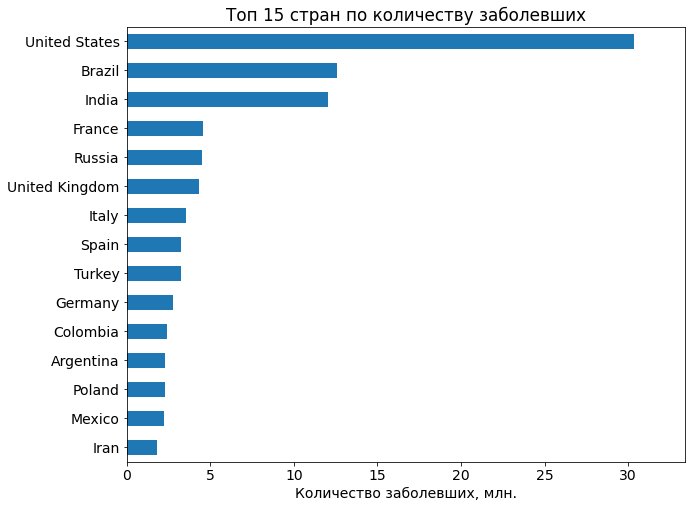

In [49]:
rcParams['font.size'] = 14
ax = max_total_cases.iloc[-15:]['cumulative_count'].plot(kind='barh',
                                                #    y=max_total_cases.index[:15],
                                                #    width=max_total_cases.cumulative_count[:15],
                                                   title='Топ 15 стран по количеству заболевших',
                                                #    xlabel='Страны',
                                                   figsize = (10,8))
xlim(0, max_total_cases['cumulative_count'].max() * 1.1)
ax.set_xlabel('Количество заболевших, млн.')                                        

### Выводы
На данной (столбчатой) диаграмме отображены данные по 15 странам с наибольшим количеством заболевших Covid-19 на данный момент.
На диаграмме видно, что есть несколько стран (Америка, Бразилия, Индия) с количеством заболевших, в несколько раз больше, чем у ближайших соседей.

## 2. Скорость роста заболеваимости/смертности по континентам

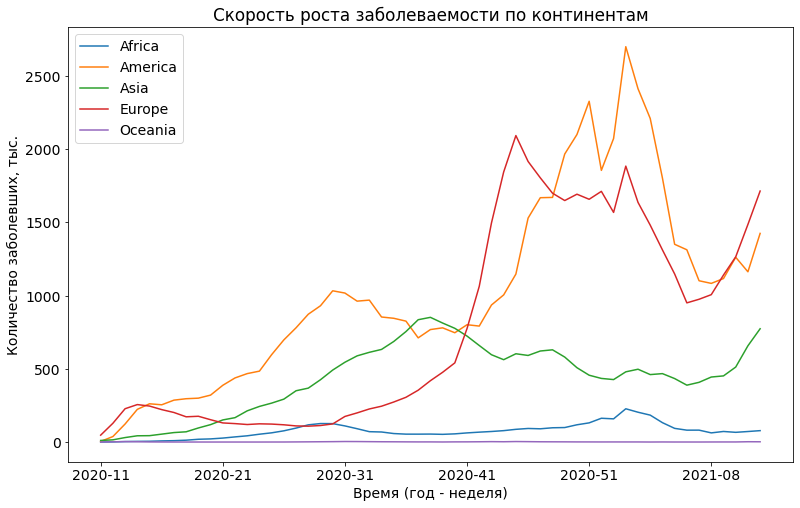

In [50]:
speed_by_continents = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')].pivot_table(index='year_week', columns='continent', values='weekly_count', aggfunc='sum')
speed_by_continents = speed_by_continents / 1000
ax = speed_by_continents.iloc[10:].plot(title='Скорость роста заболеваемости по континентам', 
                             xlabel='Время (год - неделя)', 
                             ylabel='Количество заболевших, тыс.',
                             figsize = (13,8))
ax.legend(loc='upper left')

### Выводы
На диаграмме показана динамика роста заболеваемости по континентам. На данный момент лидерами по количеству заболеваний в неделю являются Американский и Европейские регионы. Если до сентября 2020 года лидерами были Америка и Азия, то после сентября показатели Азиантского региона начали падать, тогда как Европейского - резко расти. Также графики Американского и Европейского регионов очень похожи, что может свидетельствовать: 1) о миграции населения между данными регионами; 2) о наличии сходных ситуаций, факторов - которые повышают вероятность заражения вирусом.
Африканскому региону свойственна меньшая скорость заболеваемости и ее рост заметен лишь на периоде времени в 1 год.
Странам Океании свойственна меньшая скорость роста заболеваемости и рост ее на протяжении года, в сравнении с другими регионами, незначителен.

## 3. Зависимость между численностью населения и скоростью роста заболеваемости

In [22]:
pop_count_correlation = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')].copy()
pop_count_correlation['population'] /= 1000000
pop_count_correlation['weekly_count'] /= 1000

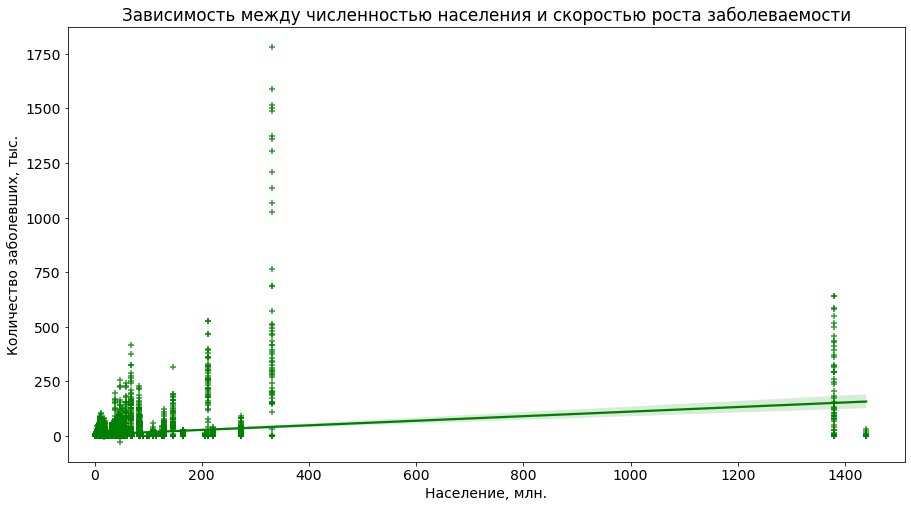

In [52]:
import seaborn as sns
rcParams['figure.figsize'] = 15,8

ax = sns.regplot(data=pop_count_correlation, x='population', y='weekly_count', color='green', marker='+')
ax.set_title('Зависимость между численностью населения и скоростью роста заболеваемости')
ax.set_xlabel('Население, млн.')
ax.set_ylabel('Количество заболевших, тыс.')
ax.set_xlim(-50, pop_count_correlation.population.max() * 1.05)

### Выводы
На диаграмме изображена зависимость количества заболевших от численности населения страны. Можно видеть, что явной линейной зависимости между этими величинами нет, хотя и есть некоторое приближение к этому.
Особо показательны(информативны) как раз случаи, не укладывающиеся в линейную зависимость: страны с населением в районе 50-100 млн. имеют большую скорость заболеваемости, чем некоторые страны с населением в 200+ млн. и 1400+ млн. Для таких ситуаций возможно большое количество трактовок - начиная с различной плотности населения и заканчивая различиями в строгости принятых мер.

## 4. Связь между скоростью роста числа заболевших и умерших

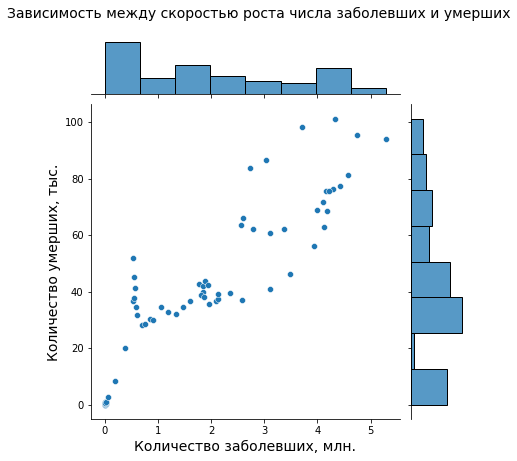

In [41]:
cases_death_correlation = df[~df.country.str.contains(r'\(total\)')].pivot_table(index='year_week', columns='indicator', values='weekly_count', aggfunc='sum')
cases_death_correlation['deaths'] /= 1000
cases_death_correlation['cases'] /= 1000000

az = sns.jointplot(x='cases', y='deaths', data=cases_death_correlation, kind='scatter')
az.fig.suptitle('Зависимость между скоростью роста числа заболевших и умерших', y=1.05, fontsize=14)
az.set_axis_labels('Количество заболевших, млн.', 'Количество умерших, тыс.', fontsize=14)

### Выводы
Изображенная на диаграмме зависимость между скоростью числа заболевших и умерших очень похожа на линейную: в целом, с увеличением числа заболевших увеличивается количество умерших.
Однако на интервалах между 30 и 40 тыс., а также между 60 и 70 тыс. умерших количество заболевших колеблется от 0,5 до 3 млн. в первом случае и от 2,5 до 4 млн. во втором. Причины этого могут быть самой разной природы: 1) особенность данных/описываемого предмета - между заболеванием и смертью есть временной промежуток, который мы не учитываем. Соответственно, рост количества умерших в период спада скорости роста заболеваемости скорее всего связан с тем, что умирают не вновь заболевшие, а те, что заразились некоторое количество времени назад; 2) аггрегирование данных - учитывая, что на данной диаграмме рассматривается суммарное количество случаев смертей/заболеваний по всему миру, могут иметь место следующие факторы: а) период спада заболеваемости в одном регионе может совпадать с периодом роста в другом; б) разница в уровне развития здравоохранения и доступности мед. помощи гражданам и другие.